In [1]:
# http://science.sciencemag.org/content/332/6027/346

import os
import io
import re
import sys
import zipfile
import subprocess
if sys.version_info < (3,):
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

SOM = ('http://science.sciencemag.org/highwire/filestream/592443/'
       'field_highwire_adjunct_files/0/1199295-Atkinson-SOM.pdf')
PDF = SOM.rpartition('/')[2]
TXT = '%s.txt' % os.path.splitext(PDF)[0]

if not os.path.exists(PDF):
    urlretrieve(SOM, PDF)

if not os.path.exists(TXT):  # requires one of popper-utils, miktex-poppler-bin, xpdf
    cmd = ['pdftotext', '-f', '21', '-l', '33', '-layout', '-nopgbrk', PDF, TXT]
    subprocess.check_call(cmd)

with io.open(TXT, encoding='utf-8') as fd:
    _, _ , S1 = fd.read().strip().partition('\n\n\n')

assert ',' not in S1

len(S1)

78729

In [2]:
S1_HEAD = """
Language Name
WALS code
Family
Latitude
Longitude
Normalized Vowel Diversity
Normalized Consonant Diversity
Normalized Tone Diversity
Total Normalized Phoneme Diversity
ISO codes
Estimated Speaker Pop. Size
Distance from best fit origin
""".strip().splitlines()

S1_FEAT = [h for h in S1_HEAD if h.startswith('Normalized ')]
S1_OUTC = S1_HEAD[-2:]

S1_DATA = S1[S1.index('\nAbkhaz '):].strip()

S1_DATA = re.sub(r'(\))([a-z]{3} )', r'\1 \2', S1_DATA)  # fix missing space
S1_DATA = re.sub(r'\n +([a-z]{3})\n(.+?)  ', r'\n\2 \1 ', S1_DATA)  # fix splitted lines
S1_DATA = S1_DATA.replace('(San Mateo del Mar)', '(San Mateo Del Mar)')  # simplify iso detection

S1_DATA = [l.strip() for l in S1_DATA.splitlines()]

len(S1_HEAD), len(S1_DATA)

(12, 504)

In [3]:
ROW = re.compile(r'''(?x)^
(.+?)\ +
([a-z]{2,3})\ +
(.+?)\ +
(-?\d+(?:\.\d+)?)\ +
(-?\d+(?:\.\d+)?)\ +
(-?\d+\.\d+)\ +
(-?\d+\.\d+)\ +
(-?\d+\.\d+)\ +
(-?\d+\.\d+)\ +
(.+?)\ +
(\d+)\ +
(\d+(?:\.\d+)?)
$''')

csv = '\n'.join(','.join(r) for r in [S1_HEAD] + [ROW.match(l).groups() for l in S1_DATA])

csv[:500]

'Language Name,WALS code,Family,Latitude,Longitude,Normalized Vowel Diversity,Normalized Consonant Diversity,Normalized Tone Diversity,Total Normalized Phoneme Diversity,ISO codes,Estimated Speaker Pop. Size,Distance from best fit origin\nAbkhaz,abk,Northwest Caucasian,43.08,41,-1.2345266,-1.5544112,-0.7687792,-1.185905651,abk,105952,5856.362\nAcoma,aco,Keresan,34.92,-107.58,-0.4846364,-0.7169629,1.86204304,0.220147906,kjq,3391,18601.19\nAndoke,adk,Andoke,-0.67,-72,1.3900889,-1.5544112,0.54663194,0.'

In [4]:
%matplotlib inline

import warnings
import itertools

import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = '%s & %s' % (left, right)
    return pd.Series(func(df[left], df[right]), index=('r', 'p'), name=name)

with io.StringIO(csv) as fd:
    s1 = pd.read_csv(fd, na_values='', keep_default_na=False, index_col='WALS code')

s1.info()
assert s1.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, abk to zun
Data columns (total 11 columns):
Language Name                         504 non-null object
Family                                504 non-null object
Latitude                              504 non-null float64
Longitude                             504 non-null float64
Normalized Vowel Diversity            504 non-null float64
Normalized Consonant Diversity        504 non-null float64
Normalized Tone Diversity             504 non-null float64
Total Normalized Phoneme Diversity    504 non-null float64
ISO codes                             504 non-null object
Estimated Speaker Pop. Size           504 non-null int64
Distance from best fit origin         504 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 47.2+ KB


In [5]:
PAIRS = list(itertools.product(S1_OUTC, S1_FEAT + ['Total Normalized Phoneme Diversity']))
pd.DataFrame([pearsonr(s1, x, y) for x, y in PAIRS]).round(3)

,r,p
Estimated Speaker Pop. Size & Normalized Vowel Diversity,0.032,0.480
Estimated Speaker Pop. Size & Normalized Consonant Diversity,0.090,0.044
Estimated Speaker Pop. Size & Normalized Tone Diversity,0.037,0.413
Estimated Speaker Pop. Size & Total Normalized Phoneme Diversity,0.082,0.065
Distance from best fit origin & Normalized Vowel Diversity,-0.394,0.000
Distance from best fit origin & Normalized Consonant Diversity,-0.260,0.000
Distance from best fit origin & Normalized Tone Diversity,-0.391,0.000
Distance from best fit origin & Total Normalized Phoneme Diversity,-0.545,0.000


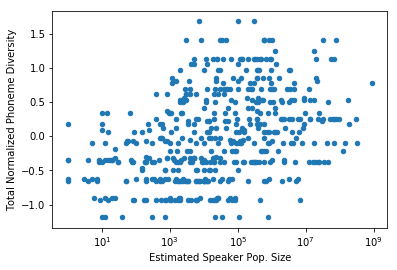

In [6]:
s1.plot.scatter(x='Estimated Speaker Pop. Size', y='Total Normalized Phoneme Diversity', logx=True);

In [7]:
pearsonr(s1.assign(Population=s1['Estimated Speaker Pop. Size'].apply(pd.np.log10)),
    'Population', 'Total Normalized Phoneme Diversity').to_frame().T.round(3)

,r,p
Population & Total Normalized Phoneme Diversity,0.385,0.0


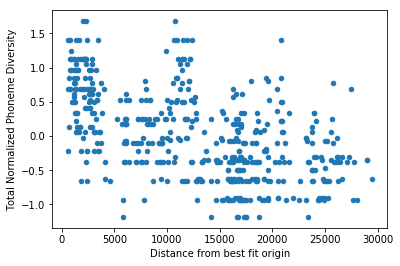

In [8]:
s1.plot.scatter(x='Distance from best fit origin', y='Total Normalized Phoneme Diversity');

In [9]:
URL = 'http://wals.info/static/download/wals-language.csv.zip'
ARCHIVE = URL.rpartition('/')[2]
EXTRACT = 'language.csv'

INFO = ['wals_code', 'Name', 'family', 'latitude', 'longitude']
FEAT = ['2A Vowel Quality Inventories', '1A Consonant Inventories', '13A Tone']

if not os.path.exists(ARCHIVE):
    urlretrieve(URL, ARCHIVE)

with zipfile.ZipFile(ARCHIVE) as archive:
    wf = pd.read_csv(archive.open(EXTRACT), encoding='utf-8', na_values='', keep_default_na=False,
        index_col=INFO[0], usecols=INFO + FEAT)

wf.info()
assert wf.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 2679 entries, aab to zzo
Data columns (total 7 columns):
Name                            2679 non-null object
latitude                        2679 non-null float64
longitude                       2679 non-null float64
family                          2679 non-null object
1A Consonant Inventories        563 non-null object
2A Vowel Quality Inventories    564 non-null object
13A Tone                        527 non-null object
dtypes: float64(2), object(5)
memory usage: 167.4+ KB


In [10]:
wf = wf.dropna(how='all', subset=FEAT)
wf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 567 entries, abi to zun
Data columns (total 7 columns):
Name                            567 non-null object
latitude                        567 non-null float64
longitude                       567 non-null float64
family                          567 non-null object
1A Consonant Inventories        563 non-null object
2A Vowel Quality Inventories    564 non-null object
13A Tone                        527 non-null object
dtypes: float64(2), object(5)
memory usage: 35.4+ KB


In [11]:
df = s1.join(wf)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, abk to zun
Data columns (total 18 columns):
Language Name                         504 non-null object
Family                                504 non-null object
Latitude                              504 non-null float64
Longitude                             504 non-null float64
Normalized Vowel Diversity            504 non-null float64
Normalized Consonant Diversity        504 non-null float64
Normalized Tone Diversity             504 non-null float64
Total Normalized Phoneme Diversity    504 non-null float64
ISO codes                             504 non-null object
Estimated Speaker Pop. Size           504 non-null int64
Distance from best fit origin         504 non-null float64
Name                                  504 non-null object
latitude                              504 non-null float64
longitude                             504 non-null float64
family                                504 non-null object
1A Consonant Invento

In [12]:
wf.loc[wf.index.difference(s1.index)].head()

,Name,latitude,longitude,family,1A Consonant Inventories,2A Vowel Quality Inventories,13A Tone
abi,Abipón,-29.000000,-61.000000,Guaicuruan,2 Moderately small,2 Average (5-6),NaN
abm,Alabama,32.333333,-87.416667,Muskogean,1 Small,1 Small (2-4),NaN
ach,Aché,-25.250000,-55.166667,Tupian,1 Small,2 Average (5-6),NaN
acm,Achumawi,41.500000,-121.000000,Hokan,2 Moderately small,2 Average (5-6),2 Simple tone system
adz,Adzera,-6.250000,146.250000,Austronesian,2 Moderately small,1 Small (2-4),NaN


In [13]:
COLS = list(itertools.chain.from_iterable(zip(S1_FEAT, FEAT)))
MAP = dict(zip(S1_FEAT, FEAT))

df[COLS] = df[COLS].apply(lambda x: x.astype('category', ordered=True).cat.codes)
mism = df[S1_FEAT].rename(columns=MAP) != df[FEAT]
mism.sum().to_frame('mismatches')

,mismatches
2A Vowel Quality Inventories,1
1A Consonant Inventories,86
13A Tone,0


In [14]:
df.loc[mism.any(axis=1), COLS].head()

,Normalized Vowel Diversity,2A Vowel Quality Inventories,Normalized Consonant Diversity,1A Consonant Inventories,Normalized Tone Diversity,13A Tone
WALS code,,,,,,
abk,0,0,0,4,0,0
aco,1,1,1,4,2,2
aea,0,0,3,2,0,0
aeg,1,1,2,3,0,0
agh,2,2,3,2,1,1


In [15]:
diff = df['Normalized Consonant Diversity'] - df['1A Consonant Inventories']
diff.value_counts().sort_index()

-4      1
-3      7
-2     10
-1     21
 0    418
 1     33
 2      9
 3      4
 4      1
dtype: int64

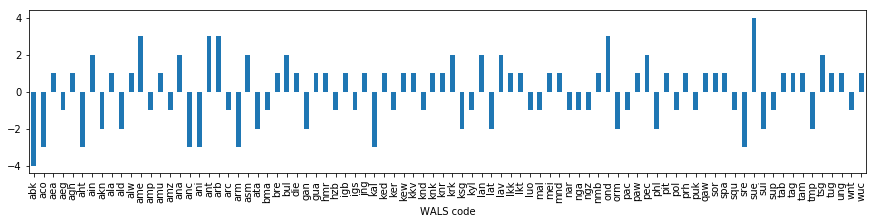

In [16]:
nf = df[diff != 0].assign(diff=diff)
nf['diff'].plot.bar(figsize=(15, 3));

In [17]:
pd.DataFrame([pearsonr(nf, 'diff', x)
    for x in ['Estimated Speaker Pop. Size', 'Distance from best fit origin']])

,r,p
diff & Estimated Speaker Pop. Size,0.076365,0.484652
diff & Distance from best fit origin,0.417043,0.000065


In [18]:
nf = df[FEAT + S1_OUTC +  ['Total Normalized Phoneme Diversity']]
nf[FEAT] = nf[FEAT].apply(scipy.stats.zscore)
nf['Diversity'] = nf[FEAT].mean(axis=1)
pd.DataFrame([pearsonr(nf, 'Diversity', x)
    for x in ['Estimated Speaker Pop. Size', 'Distance from best fit origin']])

,r,p
Diversity & Estimated Speaker Pop. Size,0.066180,1.378965e-01
Diversity & Distance from best fit origin,-0.588842,2.329109e-48


In [19]:
pearsonr(nf.assign(Population=s1['Estimated Speaker Pop. Size'].apply(pd.np.log10)),
    'Population', 'Diversity').to_frame().T

,r,p
Population & Diversity,0.413791,2.873599e-22
